/opt/conda/envs/vscode_pyspark/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


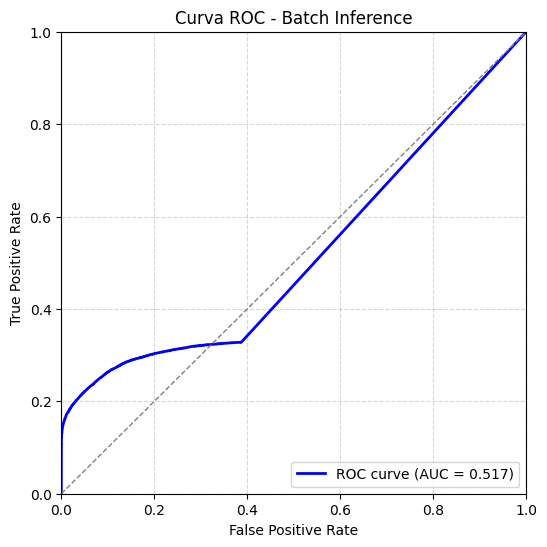

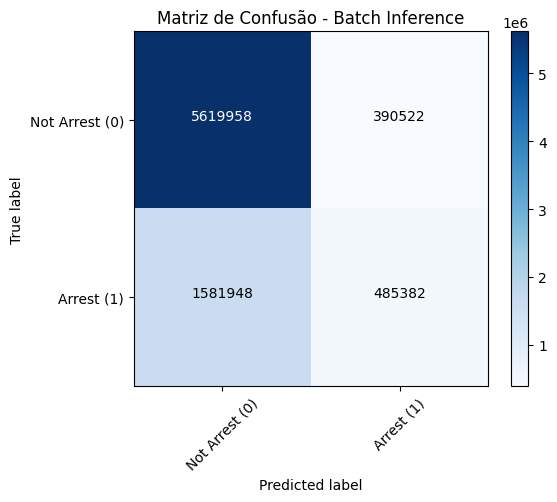

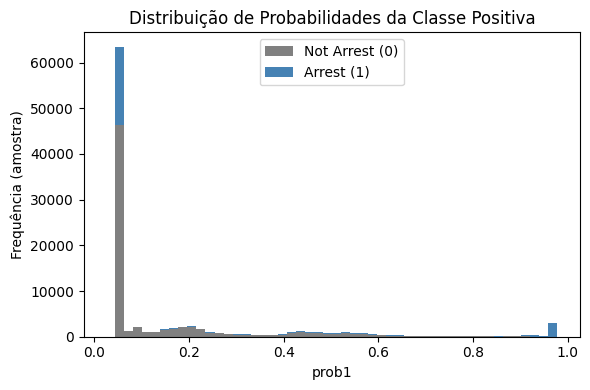

AUC (Spark) no dataset completo: 0.5162
AUC (amostra) via sklearn_roc: 0.5168

Matriz de Confusão (total):
[[5619958.  390522.]
 [1581948.  485382.]]


In [2]:
# Célula de notebook para gerar gráficos de métricas após batch inference

# Importações necessárias
%matplotlib inline

import time
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql.functions import to_timestamp, hour, dayofweek, col
from pyspark.ml.functions import vector_to_array
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import roc_curve, auc as sklearn_auc

# ─────────────────── Setup Spark e caminhos ───────────────────
INPUT_PATH   = "../dados/chicago_crime.parquet"
MODEL_PATH   = "../dados/full_model"

spark = (
    SparkSession.builder
    .appName("BatchInference_Metrics_Plots")
    .config("spark.sql.shuffle.partitions", "16")
    .config("spark.driver.memory", "8g")\
    .config("spark.executor.memory", "8g")\
    .getOrCreate()
)

# ─────────────────── 1) Carregar modelo completo ───────────────────
model = PipelineModel.load(MODEL_PATH)

# ─────────────────── 2) Ler dados brutos e criar colunas de features básicas ───────────────────
raw = spark.read.parquet(INPUT_PATH)
df_prod = (
    raw
    .withColumn("Date", to_timestamp("Date", "MM/dd/yyyy HH:mm:ss a"))
    .withColumn("Hour", hour("Date"))
    .withColumn("DayOfWeek", dayofweek("Date"))
)

# ─────────────────── 3) Rodar inferência ───────────────────
pred = model.transform(df_prod)

# ─────────────────── 4) Ajustar label para double ───────────────────
pred = pred.withColumn("ArrestDouble", col("Arrest").cast("double"))

# ─────────────────── 5) Calcular AUC global com Spark ───────────────────
evaluator = BinaryClassificationEvaluator(
    labelCol="ArrestDouble",
    rawPredictionCol="probability",
    metricName="areaUnderROC"
)
auc_spark = evaluator.evaluate(pred)

# ─────────────────── 6) Extrair amostra para ROC e PR ───────────────────
# Para não trazer todo o dataset para Pandas, vamos usar uma amostra de 100k linhas
sample_df = pred.select(
    vector_to_array("probability")[1].alias("prob1"),
    col("ArrestDouble").alias("label")
).sample(False, 100000/pred.count(), seed=42)

# Converter para Pandas
pdf_sample = sample_df.toPandas()

y_true = pdf_sample["label"].astype(float).values
y_score = pdf_sample["prob1"].astype(float).values

# Calcular pontos da curva ROC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = sklearn_auc(fpr, tpr)

# ─────────────────── 7) Calcular matriz de confusão ───────────────────
# Usaremos MulticlassMetrics no conjunto completo
pred_cm = pred.select(
    col("prediction").cast("double").alias("pred"),
    col("ArrestDouble").alias("label")
).rdd

metrics_cm = MulticlassMetrics(pred_cm)
cm_array = metrics_cm.confusionMatrix().toArray()

# ─────────────────── 8) Plotar Curva ROC ───────────────────
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("Curva ROC - Batch Inference")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# ─────────────────── 9) Plotar Matriz de Confusão ───────────────────
plt.figure(figsize=(6, 5))
plt.imshow(cm_array, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Batch Inference")
plt.colorbar()
labels = ["Not Arrest (0)", "Arrest (1)"]
tick_marks = [0, 1]
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Anotar valores dentro da matriz
thresh = cm_array.max() / 2.0
for i in range(cm_array.shape[0]):
    for j in range(cm_array.shape[1]):
        plt.text(
            j, i, int(cm_array[i, j]),
            horizontalalignment="center",
            color="white" if cm_array[i, j] > thresh else "black"
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# ─────────────────── 10) Plotar Distribuição de Probabilidades ───────────────────
plt.figure(figsize=(6, 4))
plt.hist([pdf_sample[pdf_sample["label"] == 0]["prob1"],
          pdf_sample[pdf_sample["label"] == 1]["prob1"]],
         bins=50, label=["Not Arrest (0)", "Arrest (1)"], stacked=True, color=["gray", "steelblue"])
plt.title("Distribuição de Probabilidades da Classe Positiva")
plt.xlabel("prob1")
plt.ylabel("Frequência (amostra)")
plt.legend(loc="upper center")
plt.tight_layout()
plt.show()

# ─────────────────── 11) Exibir métricas numéricas ───────────────────
print(f"AUC (Spark) no dataset completo: {auc_spark:.4f}")
print(f"AUC (amostra) via sklearn_roc: {roc_auc:.4f}")
print("\nMatriz de Confusão (total):")
print(cm_array)

# Fim do notebook